In [1]:
%reset -f
%matplotlib inline
from copy import copy
from itertools import permutations
from itertools import product as c_product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from aux import Generic
from ntwk import LIFNtwk, join_w
from disp import print_red, raster, set_font_size, spaced_colors

import PARAMS as P_GLOBAL

cc = np.concatenate

# PARAMETERS AND CROSS-SIMULATION SUBROUTINES
<a id="params"></a>

[Jump to simulations](#simulations)

## Parameters

In [2]:
P = Generic(
    
    N_OUT=500,  # number of OUT neurons
    N_INH=100,  # number of INH neurons
    
    T_M_OUT=P_GLOBAL.T_M_PC,  # membrane time constant for OUT neurons
    E_L_OUT=P_GLOBAL.E_L_PC,  # rest/leak potential for OUT neurons
    V_TH_OUT=P_GLOBAL.V_TH_PC,  # spike threshold for OUT neurons
    V_RESET_OUT=P_GLOBAL.V_RESET_PC,  # reset potential for OUT neurons
    
    T_M_INH=P_GLOBAL.T_M_INH,  # membrane time constant for INH neurons
    E_L_INH=P_GLOBAL.E_L_INH,  # rest/leak potential for INH neurons
    V_TH_INH=P_GLOBAL.V_TH_INH,  # spike threshold for INH neurons
    V_RESET_INH=P_GLOBAL.V_RESET_INH,  # reset potential for INH neurons
    
    T_R=0.002,  # refractory period for all neurons (s)
    
    E_A=P_GLOBAL.E_A,  # AMPA reversal potential
    E_N=P_GLOBAL.E_N,  # NMDA reversal potential
    E_G=P_GLOBAL.E_G,  # GABA reversal potential
    
    T_A=P_GLOBAL.T_A,  # AMPA time constant
    T_N=P_GLOBAL.T_N,  # NMDA time constant
    T_G=P_GLOBAL.T_G,  # GABA time constant
    
    W_A_OUT_OUT=0.001,  # recurrent OUT-OUT AMPA cxn weights
    W_A_OUT_IN=P_GLOBAL.W_A_PC_PL,  # FF IN->OUT AMPA cxn weights
    W_A_INH_OUT=0.007,  # recurrent OUT->INH AMPA cxn weights
    
    W_N_OUT_CTL_I=P_GLOBAL.W_N_PC_EC_I,  # initial CTL->OUT NMDA cxn weight
    W_N_OUT_CTL_F=P_GLOBAL.W_N_PC_EC_F,  # maximum/final CTL->OUT NMDA cxn weight
    
    W_G_OUT_INH=0.024,  # recurrent INH->OUT GABA cxn weight
    
    P_A_OUT_OUT=0.05,  # OUT->OUT AMPA cxn probability
    P_A_INH_OUT=0.5,  # OUT->INH AMPA cxn probability
    
    T_W=P_GLOBAL.T_W,  # CTL->OUT NMDA weight change timescale
    T_C=P_GLOBAL.T_C,  # plasticity spk-count integration timescale
    C_S=P_GLOBAL.C_S,  # spk-count threshold
    B_C=P_GLOBAL.B_C,  # spk-count nonlinearity slope
    
    DT=P_GLOBAL.DT,  # simulation timestep
    
    FR_STORE=250,  # item neuron firing rate during storage
    
    T_STORE_0=1,  # item storage start time (s)
    T_STORE_1=3,  # item storage end time (s)
    
    FR_RECALL=70,  # ctl neuron firing rate during recall
    
    T_RECALL_0=5,  # item recall start time (s)
    T_RECALL_1=7,  # item recall end time (s)
    
    T_END=8,  # simulation end time (s)
    
    NOISE_STD=0.002,  # noise level (V)
    
    Q=0.2,  # probability of an arbitrary neuron participating in an arbitrary item
    
    T_FR_MA=0.05,  # window used to calculate firing rate moving averages (s)
)

## Network structure

### Item assignment

In [3]:
def assign_items(n, q, q_star, test=False):
    """
    Probabilistically assign item labels to n neurons.
    Exactly 4 items are considered, with hard-coded 
    combination probabilities. Generalization to N items
    is straightforward but beyond the scope of this project.
    
    :param n: number of neurons
    :param q: prob. of neuron being in any given item group
    :param q_star: prob. of neuron being in any specific second
        item group, given that it is in another first item group
        
    :return: n x 4 boolean array of item assignments
    """
    
    # specify all item combinations
    item_combos = [
        [],  # row 0
        [0,], [1,], [2,], [3,],  # row 1
        [0, 1], [0, 2], [0, 3], [1, 2], [1, 3], [2, 3],  # row 2
        [0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3],  # row 3
        [0, 1, 2, 3],  # row 4
    ]
    
    # compute probability of each combination
    
    ## p of row 1
    a = q * ((1 - q_star)**3)
    ## p of row 2
    b = q * q_star * ((1 - q_star)**2)
    ## p of row 3
    c = q * (q_star**2) * (1 - q_star)
    ## p of row 4
    d = q * (q_star**3)
    
    ## validate probabilities
    assert 4*a + 6*b + 4*c + d < 1
    
    ## full vector
    p = [
        1 - (4*a + 6*b + 4*c + d),  # row 0
        a, a, a, a,  # row 1
        b, b, b, b, b, b,  # row 2
        c, c, c, c,  # row 3
        d,  # row 4
    ]
    
    # assign labels
    labels = np.zeros((n, 4), bool)
    
    for i in range(n):
        
        # sample item assignment for i-th neuron
        item_combo = np.random.choice(item_combos, p=p)
        
        # convert to boolean
        labels[i, item_combo] = True
    
    if not test:
        
        return labels
    
    else:
        
        # estimate q
        q_hat = labels.mean()
        
        # estimate q_star
        q_star_hat = np.array([
            labels[labels[:, i], :][:, j].mean()
            for i, j in permutations(range(4), 2)
        ])
        
        return Generic(
            labels=labels, q_hat=q_hat, q_star_hat=q_star_hat)

In [4]:
def sort_item_labels(labels_unsorted):
        
    labels_sorted = [[] for _ in range(5)]

    for label in labels_unsorted:
        items = label.nonzero()[0]

        # place item in random group corresponding to one of its items
        if not items.size:
            group = 0
        else:
            group = np.random.choice(items) + 1

        labels_sorted[group].append(label)

    # make final sorted labels array
    labels_sorted = [np.array(labels_) for labels_ in labels_sorted]
    labels_sorted = cc(labels_sorted, 0)

    return labels_sorted

#### Test

In [5]:
def test_assign_items_no_overlap():
    print_red('\n>> test_assign_items_no_overlap...\n'.upper())
    
    n = 10000
    q = 0.2
    q_star = 0.0
    
    rslt = assign_items(n=n, q=q, q_star=q_star, test=True)
    
    # ensure correct item probability  
    print_red('    q = {}'.format(q))
    print_red('    q_hat = {0:.4f}\n'.format(rslt.q_hat))

    # ensure no overlap
    print_red('    q* = {}'.format(q_star))
    print_red('    q*_hat = {0:.4f}\n'.format(rslt.q_star_hat.mean()))
    
    # ensure only 0 or 1 item per neuron
    print_red('    unique items per neuron ([0, 1]) = {}\n'.format(set(rslt.labels.sum(1))))
    

def test_assign_items_complete_overlap():
    print_red('\n>> test_assign_items_complete_overlap...\n'.upper())
    
    n = 10000
    q = 0.2
    q_star = 1.0
    
    rslt = assign_items(n=n, q=q, q_star=q_star, test=True)
    
    # ensure correct item probability  
    print_red('    q = {}'.format(q))
    print_red('    q_hat = {0:.4f}\n'.format(rslt.q_hat))

    # ensure complete overlap
    print_red('    q* = {}'.format(q_star))
    print_red('    q*_hat = {0:.4f}\n'.format(rslt.q_star_hat.mean()))
    
    # ensure only 0 or 4 items per neuron
    print_red('    unique items per neuron ([0, 4]) = {}\n'.format(set(rslt.labels.sum(1))))
    

def test_assign_items_partial_overlap():
    print_red('\n>> test_assign_items_partial_overlap...\n'.upper())
    
    n = 10000
    q = 0.2
    q_star = 0.5
    
    rslt = assign_items(n=n, q=q, q_star=q_star, test=True)
    
    # ensure correct item probability  
    print_red('    q = {}'.format(q))
    print_red('    q_hat = {0:.4f}\n'.format(rslt.q_hat))

    # ensure correct partial overlap
    print_red('    q* = {}'.format(q_star))
    print_red('    q*_hat = {0:.4f}\n'.format(rslt.q_star_hat.mean()))
    
    # ensure any number of items per neuron
    print_red('    unique items per neuron ([0, 1, 2, 3, 4]) = {}\n'.format(set(rslt.labels.sum(1))))
            

np.random.seed(0)

test_assign_items_no_overlap()
test_assign_items_complete_overlap()
test_assign_items_partial_overlap()


>> TEST_ASSIGN_ITEMS_NO_OVERLAP...

    q = 0.2
    q_hat = 0.1985

    q* = 0.0
    q*_hat = 0.0000

    unique items per neuron ([0, 1]) = {0, 1}


>> TEST_ASSIGN_ITEMS_COMPLETE_OVERLAP...

    q = 0.2
    q_hat = 0.2014

    q* = 1.0
    q*_hat = 1.0000

    unique items per neuron ([0, 4]) = {0, 4}


>> TEST_ASSIGN_ITEMS_PARTIAL_OVERLAP...

    q = 0.2
    q_hat = 0.2005

    q* = 0.5
    q*_hat = 0.5047

    unique items per neuron ([0, 1, 2, 3, 4]) = {0, 1, 2, 3, 4}



Tests passed if:
1. Estimates (q_hat, q_star_hat) are near truth values.
1. If unique items per neuron match parentheticals.

#### Test

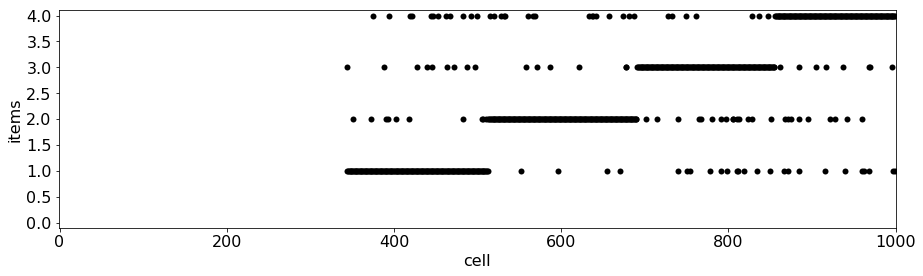

In [6]:
def test_sort_item_labels():
    
    n = 1000
    q = 0.2
    q_star = 0.1
    
    labels = sort_item_labels(assign_items(n=n, q=q, q_star=q_star))
    
    cells, items = labels.nonzero()
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 4))
    
    ax.scatter(cells, items+1, c='k', lw=0)
    ax.set_xlim(-1, n)
    ax.set_ylim(-0.1, 4.1)
    
    ax.set_xlabel('cell')
    ax.set_ylabel('items')
    
    set_font_size(ax, 16)
    
test_sort_item_labels()

Test passed if thick lines start at around cell 250 and resemble staircase until cell 1000, with a handful of random dots scattered about for cells > 250.

### Recurrent OUT-->OUT weights

In [7]:
def make_w_a_out_out(labels_out, p_0, p_1, P, test=False):
    """
    Create recurrent AMPA weight matrix given neuron labeling.
    
    :param _out: n x 4 boolean array indicating neuron-item pairings
    :param p_0: expected OUT->OUT cxn probability, avgd over all neurons indiscriminately
    :param p_1: expected OUT->OUT cxn probability for neurons with same item label
    
    :return: n_out x n_out matrix of OUT->OUT AMPA weights
    """
    
    n_out = len(labels_out)
    
    # get candidate intra-item cxns
    masks_intra = []
    
    for i in range(4):
        
        # get intra-cxns for item i
        mask_intra_ = np.outer(labels_out[:, i], labels_out[:, i])
        
        # zero self-cxns
        np.fill_diagonal(mask_intra_, 0)
        
        masks_intra.append(mask_intra_)
    
    # take union of intra-item cxn possibilities
    mask_intra = np.logical_or.reduce(masks_intra)
    n_intra = mask_intra.sum()
    
    # build cxn matrix
    cxn = np.zeros((n_out, n_out), bool)
    
    # set intra-item cnxs
    assert 0 <= p_1 <= 1
    cxn[mask_intra] = np.random.binomial(1, p_1, n_intra)
    
    # set non-intra cxns
    p_2 = ((n_out * (n_out - 1) * p_0) - (n_intra * p_1)) / ((n_out * (n_out - 1)) - n_intra)
    
    assert 0 <= p_2 <= 1
    cxn[~mask_intra] = np.random.binomial(1, p_2, (~mask_intra).sum())
    
    # zero self-cxns
    np.fill_diagonal(cxn, 0)
    
    # convert to weight matrix
    w = cxn * P.W_A_OUT_OUT
    
    if not test:
        
        return w
    
    else:
        
        # estimate p_0
        mask_non_self = ~np.eye(n_out, dtype=bool)
        p_0_hat = (w > 0)[mask_non_self].mean()
        
        # estimate p_1
        p_1_hat = np.array([(w > 0)[mask_intra].mean() for mask_intra in masks_intra])
        
        return Generic(w=w, p_0_hat=p_0_hat, p_1_hat=p_1_hat)

#### Test

In [8]:
def test_make_w_a_out_out_no_overlap(P):
    print_red('\n>> test_make_w_a_out_out_no_overlap...\n'.upper())
    
    n = 10000
    q = 0.2
    q_star = 0
    
    p_0 = 0.1
    p_1s = [0, 0.1, 0.2]
    
    labels_out = assign_items(n=n, q=q, q_star=q_star)
    
    for p_1 in p_1s:
        
        rslt = make_w_a_out_out(labels_out, p_0, p_1, P, test=True)
        
        print_red('    p_0 = {}'.format(p_0))
        print_red('    p_0_hat = {0:.4f}\n'.format(rslt.p_0_hat))
        
        print_red('    p_1 = {}'.format(p_1))
        print_red('    p_1_hat = {0:.4f}\n'.format(rslt.p_1_hat.mean()))
        

def test_make_w_a_out_out_partial_overlap(P):
    print_red('\n>> test_make_w_a_out_out_partial_overlap...\n'.upper())
    
    n = 10000
    q = 0.2
    q_star = 0.5
    
    p_0 = 0.1
    p_1s = [0, 0.1, 0.2]
    
    labels_out = assign_items(n=n, q=q, q_star=q_star)
    
    for p_1 in p_1s:
        
        rslt = make_w_a_out_out(labels_out, p_0, p_1, P, test=True)
        
        print_red('    p_0 = {}'.format(p_0))
        print_red('    p_0_hat = {0:.4f}\n'.format(rslt.p_0_hat))
        
        print_red('    p_1 = {}'.format(p_1))
        print_red('    p_1_hat = {0:.4f}\n'.format(rslt.p_1_hat.mean()))
        

test_make_w_a_out_out_no_overlap(P)
test_make_w_a_out_out_partial_overlap(P)


>> TEST_MAKE_W_A_OUT_OUT_NO_OVERLAP...

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0
    p_1_hat = 0.0000

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0.1
    p_1_hat = 0.0999

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0.2
    p_1_hat = 0.2000


>> TEST_MAKE_W_A_OUT_OUT_PARTIAL_OVERLAP...

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0
    p_1_hat = 0.0000

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0.1
    p_1_hat = 0.0999

    p_0 = 0.1
    p_0_hat = 0.1000

    p_1 = 0.2
    p_1_hat = 0.1999



Tests passed if:
1. All estimates (*_hat) approximate truth values.

### Recurrent OUT-->INH weights

In [9]:
def make_w_a_inh_out(labels_out, labels_inh, P):
    """
    Create out->inh AMPA cxn mask. Nonzero cxn from out->inh cell
    exists with probability P.P_A_INH_OUT if (1) out & inh share
    at least 1 item, or (2) out & inh both have no items.
    
    item, and probability 0 otherwise.
    
    :return: n_inh x n_out matrix of OUT->INH AMPA weights
    """
    n_out = len(labels_out)
    n_inh = len(labels_inh)
    
    # loop over all neuron pairs
    w_a_inh_out = np.zeros((n_inh, n_out))
    
    for inh in range(n_inh):
        for out in range(n_out):
            
            # sample possible cxn if any shared items
            # or if neither has any items
            shared = np.any(labels_inh[inh] & labels_out[out])
            neither = not np.any(labels_inh[inh] | labels_out[out])
            
            if shared or neither:
                cxn = np.random.binomial(1, P.P_A_INH_OUT)
                w_a_inh_out[inh, out] = P.W_A_INH_OUT * cxn
    
    return w_a_inh_out

#### Test

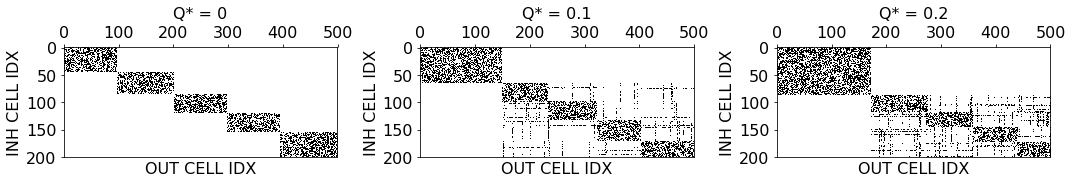

In [10]:
def test_make_w_a_inh_out():
    
    n_out = 500
    n_inh = 200
    q = 0.2
    q_stars = [0, 0.1, 0.2]
    
    P = Generic(P_A_INH_OUT=0.5, W_A_INH_OUT=1)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
    
    for q_star, ax in zip(q_stars, axs):
        
        labels_out = sort_item_labels(assign_items(n_out, q, q_star))
        labels_inh = sort_item_labels(assign_items(n_inh, q, q_star))
        
        w_a_inh_out = make_w_a_inh_out(labels_out, labels_inh, P=P)
        
        ax.spy(w_a_inh_out)
        
        ax.set_xlabel('OUT CELL IDX')
        ax.set_ylabel('INH CELL IDX')
        
        ax.xaxis.tick_top()
        
        ax.set_title('Q* = {}\n'.format(q_star))
        
        set_font_size(ax, 16)
        
test_make_w_a_inh_out()

Test passed if all axes are block diagonal, with size of first block increasing from left panel to right panel, as well as noise surrounding last four blocks.

### Recurrent INH-->OUT weights

In [11]:
def make_w_g_out_inh(labels_out, labels_inh, p_g_out_inh, P):
    """
    Create inh->out GABA cxn mask. Nonzero cxn from out->inh cell
    exists with probability P.P_G_OUT_INH if out & inh do not
    have identical item sets.
    
    :param p_g_out_inh: INH->OUT GABA cxn probability
    
    :return: n_out x n_inh matrix of INH->OUT GABA weights
    """
    n_out = len(labels_out)
    n_inh = len(labels_inh)
    
    # loop over all neuron pairs
    w_g_out_inh = np.zeros((n_out, n_inh))
    
    for out in range(n_out):
        for inh in range(n_inh):
            
            # add cxn if no overlapping items between out & inh
            # and they don't both have zero items
            no_overlap = ~np.any(labels_out[out] & labels_inh[inh])
            both_zero = ~np.any(labels_out[out] | labels_inh[inh])
            
            if no_overlap and not both_zero:
                cxn = np.random.binomial(1, p_g_out_inh)
                w_g_out_inh[out, inh] = P.W_G_OUT_INH * cxn
    
    return w_g_out_inh

#### Test

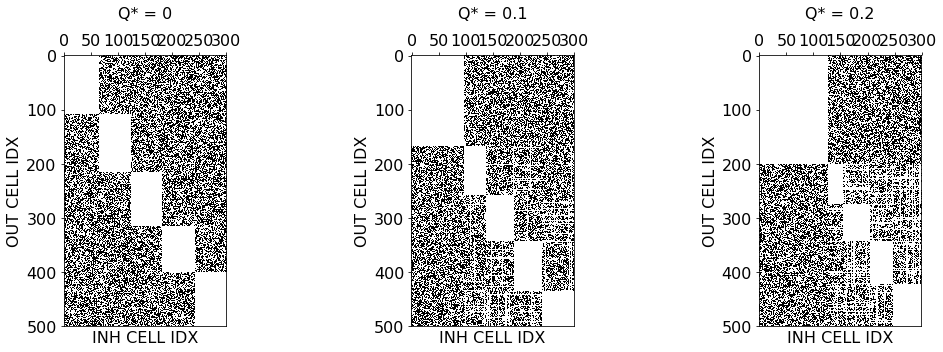

In [12]:
def test_make_w_g_out_inh():
    
    n_out = 500
    n_inh = 300
    q = 0.2
    q_stars = [0, 0.1, 0.2]
    
    p_g_out_inh = 0.5
    
    P = Generic(W_G_OUT_INH=1)
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
    
    for q_star, ax in zip(q_stars, axs):
        
        labels_out = sort_item_labels(assign_items(n_out, q, q_star))
        labels_inh = sort_item_labels(assign_items(n_inh, q, q_star))
        
        w_a_inh_out = make_w_g_out_inh(labels_out, labels_inh, p_g_out_inh, P=P)
        
        ax.spy(w_a_inh_out)
        
        ax.set_xlabel('INH CELL IDX')
        ax.set_ylabel('OUT CELL IDX')
        
        ax.xaxis.tick_top()
        
        ax.set_title('Q* = {}\n'.format(q_star))
        
        set_font_size(ax, 16)
        
test_make_w_g_out_inh()

Test passed if all panels show "inverse" block diagonal matrices, with first block size increasing from left to right panel, with no noise inside blocks.

### Upstream AMPA weights (from item inputs)

In [13]:
def make_w_a_out_in(labels_out, P):
    """
    :param labels_out: n_out x 4 boolean matrix of neuron-item pairings
    
    :return: n_out x n_in matrix of IN->OUT weights 
    """
    
    n_out = len(labels_out)
    
    # IN (item inputs)
    cxns_a_out_in = []
    
    # loop over items
    for label in labels_out.T:
        # make one input unit per output unit in this item
        cxn_a_out_in = np.zeros((n_out, label.sum()), bool)
        
        for j, idx in enumerate(label.nonzero()[0]):
            cxn_a_out_in[idx, j] = True
            
        cxns_a_out_in.append(cxn_a_out_in)
        
    w_a_out_in = cc(cxns_a_out_in, 1) * P.W_A_OUT_IN
    
    return w_a_out_in

#### Test

In [14]:
def test_make_w_a_out_in():
    
    labels_out = np.array([
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
    ]).T
    
    w_a_out_in = make_w_a_out_in(labels_out, Generic(W_A_OUT_IN=2.))
    
    assert w_a_out_in.shape == (len(labels_out), 2 + 4 + 5)
    
    w_a_out_in_correct = 2. * np.array([
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        
        [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
    ]).T
    
    np.testing.assert_array_equal(w_a_out_in, w_a_out_in_correct)
    
    print_red('All tests passed.')
    
test_make_w_a_out_in()

All tests passed.


### Upstream NMDA weights (from control inputs)

In [15]:
def make_w_n_out_ctl(labels_out, P):
    """
    :param labels_out: n_out x 4 boolean matrix of neuron-item pairings
    
    :return: n_out x n_ctl matrix of CTL->OUT NMDA weights
    """
    
    return np.eye(len(labels_out)) * P.W_N_OUT_CTL_I

### Top-level build

In [16]:
def make_ntwk(q_star, p_0, p_1, p_g_out_inh, P):
    """Create LIFNtwk with plastic CTL->OUT synapses.
    
    :param q_star: probability of neuron being in item B given that it's in item A
    :param p_0: expected OUT->OUT cxn probability, avgd over all neurons indiscriminately
    :param p_1: expected OUT->OUT cxn probability for neurons with same item label
    :param p_g_out_inh: INH->OUT GABA cxn probability
    """
    
    # assign OUT and INH item labels and sort into balanced groups
    labels_out = sort_item_labels(assign_items(P.N_OUT, P.Q, q_star))
    labels_inh = sort_item_labels(assign_items(P.N_INH, P.Q, q_star))
    
    # get recurrent cxns
    masks_rcr = {
        'OUT': cc([np.ones(P.N_OUT, bool), np.zeros(P.N_INH, bool)]),
        'INH': cc([np.zeros(P.N_OUT, bool), np.ones(P.N_INH, bool)]),
    }
    
    ws_rcr_partial={
        'AMPA': {
            ('OUT', 'OUT'): make_w_a_out_out(labels_out, p_0=P.P_A_OUT_OUT, p_1=p_1, P=P),
            ('INH', 'OUT'): make_w_a_inh_out(labels_out, labels_inh, P),
        },
        'GABA': {
            ('OUT', 'INH'): make_w_g_out_inh(labels_out, labels_inh, p_g_out_inh, P),
        }
    }
    
    ws_rcr = join_w(targs=masks_rcr, srcs=masks_rcr, ws=ws_rcr_partial)
    
    # get upstream cxns
    n_in = labels_out.sum()
    n_ctl = P.N_OUT
    
    masks_up = {
        'IN': cc([np.ones(n_in, bool), np.zeros(n_ctl, bool)]),
        'CTL': cc([np.zeros(n_in, bool), np.ones(n_ctl, bool)]),
    }
    
    ws_up_partial={
        'AMPA': {
            ('OUT', 'IN'): make_w_a_out_in(labels_out, P),
        },
        'NMDA': {
            ('OUT', 'CTL'): make_w_n_out_ctl(labels_out, P),
        },
    }
    
    ws_up = join_w(targs=masks_rcr, srcs=masks_up, ws=ws_up_partial)
    
    # make plasticity masks
    masks_plastic_partial = {
        'NMDA': {('OUT', 'CTL'): np.eye(n_ctl, dtype=bool)},
    }
    
    masks_plastic = join_w(targs=masks_rcr, srcs=masks_up, ws=masks_plastic_partial)
    
    # set synaptic params
    es_syn = {'AMPA': P.E_A, 'NMDA': P.E_N, 'GABA': P.E_G}
    ts_syn = {'AMPA': P.T_A, 'NMDA': P.T_N, 'GABA': P.T_G}
    
    # set plasticity params
    plasticity = {
        'masks': masks_plastic,
        'w_ec_ca3_maxs': {'AMPA': np.nan, 'NMDA': P.W_N_OUT_CTL_F, 'GABA': np.nan},
        'T_W': P.T_W,
        'T_C': P.T_C,
        'C_S': P.C_S,
        'BETA_C': P.B_C,
    }
    
    # make ntwk
    ntwk = LIFNtwk(
        t_m=cc([np.repeat(P.T_M_OUT, P.N_OUT), np.repeat(P.T_M_INH, P.N_INH)]),
        e_l=cc([np.repeat(P.E_L_OUT, P.N_OUT), np.repeat(P.E_L_INH, P.N_INH)]),
        v_th=cc([np.repeat(P.V_TH_OUT, P.N_OUT), np.repeat(P.V_TH_INH, P.N_INH)]),
        v_reset=cc([np.repeat(P.V_RESET_OUT, P.N_OUT), np.repeat(P.V_RESET_INH, P.N_INH)]),
        t_r=cc([np.repeat(P.T_R, P.N_OUT), np.repeat(P.T_R, P.N_INH)]),
        es_syn=es_syn,
        ts_syn=ts_syn,
        ws_rcr=ws_rcr,
        ws_up=ws_up,
        plasticity=plasticity)
    
    ntwk.labels_out = labels_out
    
    ntwk.n_out = P.N_OUT
    ntwk.n_inh = P.N_INH
                
    ntwk.n_in = n_in
    ntwk.n_ctl = n_ctl
    
    ntwk.masks_rcr = masks_rcr
    ntwk.masks_up = masks_up
    
    return ntwk

#### Test

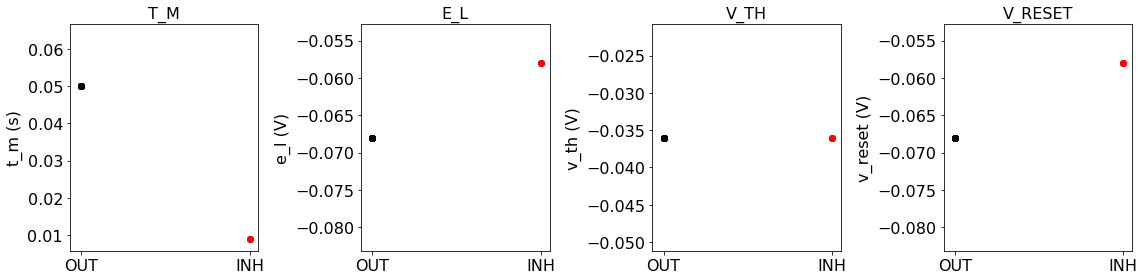

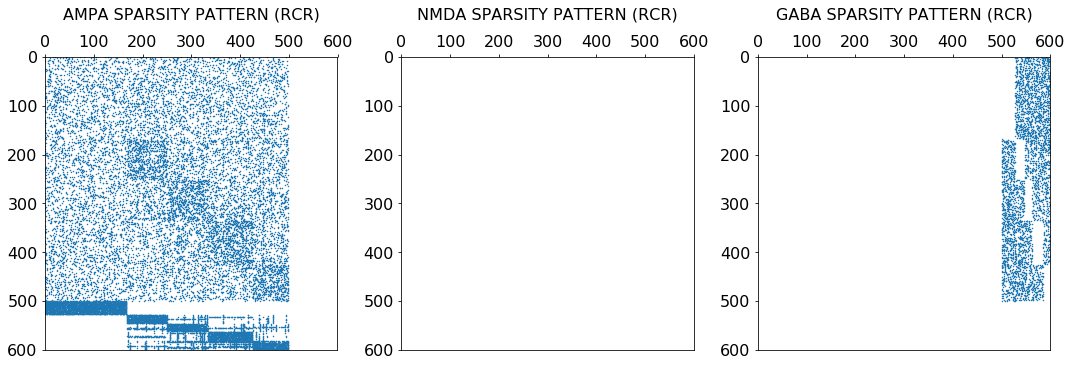

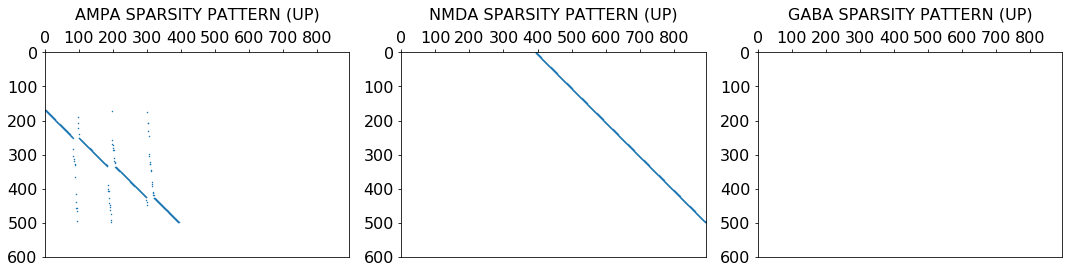

In [17]:
def test_make_ntwk():
    
    np.random.seed(0)
    
    ntwk = make_ntwk(q_star=0.1, p_0=0.05, p_1=0.1, p_g_out_inh=0.1, P=P)
    
    # plot intrinsic params
    fig, axs = plt.subplots(1, 4, figsize=(16, 4), tight_layout=True)
    
    mask_out = ntwk.masks_rcr['OUT']
    mask_in = ntwk.masks_rcr['INH']
    
    axs[0].scatter(np.zeros(ntwk.n_out), ntwk.t_m[mask_out], color='k', lw=0)
    axs[0].scatter(np.ones(ntwk.n_inh), ntwk.t_m[mask_in], color='r', lw=0)
    axs[0].set_ylabel('t_m (s)')
    axs[0].set_title('T_M')
    
    axs[1].scatter(np.zeros(ntwk.n_out), ntwk.e_l[mask_out], color='k', lw=0)
    axs[1].scatter(np.ones(ntwk.n_inh), ntwk.e_l[mask_in], color='r', lw=0)
    axs[1].set_ylabel('e_l (V)')
    axs[1].set_title('E_L')
    
    axs[2].scatter(np.zeros(ntwk.n_out), ntwk.v_th[mask_out], color='k', lw=0)
    axs[2].scatter(np.ones(ntwk.n_inh), ntwk.v_th[mask_in], color='r', lw=0)
    axs[2].set_ylabel('v_th (V)')
    axs[2].set_title('V_TH')
    
    axs[3].scatter(np.zeros(ntwk.n_out), ntwk.v_reset[mask_out], color='k', lw=0)
    axs[3].scatter(np.ones(ntwk.n_inh), ntwk.v_reset[mask_in], color='r', lw=0)
    axs[3].set_ylabel('v_reset (V)')
    axs[3].set_title('V_RESET')
    
    for ax in axs:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['OUT', 'INH'])
        
        set_font_size(ax, 16)
    
    # plot recurrent connectivity
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
    
    axs[0].spy(ntwk.ws_rcr['AMPA'].todense(), markersize=0.5)
    axs[0].set_title('AMPA SPARSITY PATTERN (RCR)\n')
    
    axs[1].spy(ntwk.ws_rcr['NMDA'].todense(), markersize=0.5)
    axs[1].set_title('NMDA SPARSITY PATTERN (RCR)\n')
    
    axs[2].spy(ntwk.ws_rcr['GABA'].todense(), markersize=0.5)
    axs[2].set_title('GABA SPARSITY PATTERN (RCR)\n')
    
    for ax in axs:
        ax.xaxis.tick_top()
        set_font_size(ax, 16)
        
    # plot upstream connectivity
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
    
    axs[0].spy(ntwk.ws_up_init['AMPA'].todense(), markersize=0.5)
    axs[0].set_title('AMPA SPARSITY PATTERN (UP)\n')
    
    axs[1].spy(ntwk.ws_up_init['NMDA'].todense(), markersize=0.5)
    axs[1].set_title('NMDA SPARSITY PATTERN (UP)\n')
    
    axs[2].spy(ntwk.ws_up_init['GABA'].todense(), markersize=0.5)
    axs[2].set_title('GABA SPARSITY PATTERN (UP)\n')
    
    for ax in axs:
        ax.xaxis.tick_top()
        set_font_size(ax, 16)
        
    return ntwk
        
test_ntwk = test_make_ntwk()

Test passed if:

* (0, 0): cxns within upper left 500 x 500 block exist, with four block-shaped structures within, anchored to lower right corner (OUT->OUT cxns); cxns at different density within lower left 50 x 500 block (OUT->INH cxns), showing block diagonal structure; no other cxns
* (0, 1): empty
* (0, 2): cxns within upper right 500 x 50 block only (INH->OUT cxns), themselves showing "inverse" block diagonal structure
* (1, 0): diagonal line in left half of matrix broken into 4 chunks, with scatter spreading around breaks (item-specific IN->OUT cxns)
* (1, 1): diagonal line in right half of matrix (CTL->OUT cxns)
* (1, 2): empty

## Stimulation paradigm

### Upstream spks with item info

In [18]:
def make_spks_up(ntwk, items, P):
    """Create an input spike train to imprint and recall items."""
    
    t = np.arange(0, P.T_END, P.DT)
    
    spks_up = np.zeros((len(t), ntwk.n_in + ntwk.n_ctl))
    
    # storage
    t_mask_store = (P.T_STORE_0 <= t) & (t < P.T_STORE_1)

    starts_ends = [0] + list(ntwk.labels_out.sum(0).cumsum())
    
    for i in items:
        start = starts_ends[i]
        end = starts_ends[i+1]
        
        spks_up[t_mask_store, start:end] = \
            np.random.poisson(P.DT * P.FR_STORE, size=(t_mask_store.sum(), end-start))
            
    # recall
    mask_recall = (P.T_RECALL_0 <= t) & (t < P.T_RECALL_1)
    spks_up[mask_recall, -ntwk.n_ctl:] = \
        np.random.poisson(P.DT * P.FR_RECALL, size=(mask_recall.sum(), ntwk.n_ctl))
    
    return spks_up

#### Test

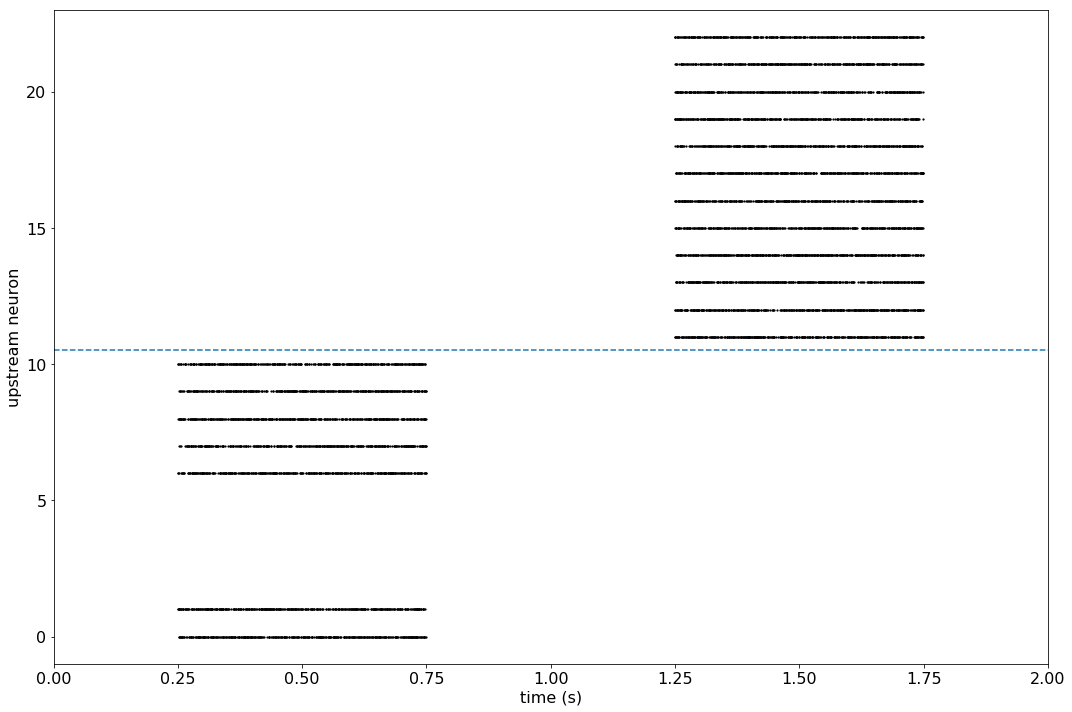

In [19]:
def test_make_spks_up(P):
    
    labels_out = np.array([
        [1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0],
        [0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1],
    ]).T
    
    p = Generic(
        T_END=2,
        DT=P.DT,
        T_STORE_0=0.25,
        T_STORE_1=0.75,
        FR_STORE=0.5/P.DT,
        T_RECALL_0=1.25,
        T_RECALL_1=1.75,
        FR_RECALL=0.5/P.DT)
    
    ntwk = Generic(n_ctl=len(labels_out), n_in=labels_out.sum(), labels_out=labels_out)
    spks_up = make_spks_up(ntwk, [0, 2], p)
    
    assert spks_up.shape[1] == (ntwk.n_in + ntwk.n_ctl)
    
    spk_times, spk_idxs = spks_up.nonzero()
    
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), tight_layout=True)
    
    ax.scatter(P.DT * spk_times, spk_idxs, s=5, lw=0, c='k')
    ax.axhline(10.5, ls='--')
    
    ax.set_xlim(0, 2)
    ax.set_ylim(-1, spks_up.shape[1])
    
    ax.set_xlabel('time (s)')
    ax.set_ylabel('upstream neuron')
    
    set_font_size(ax, 16)
    
test_make_spks_up(P)

Test passed if rows 0 - 1 and 6 - 10 (inclusive) are active from 0.25 to 0.75 s, and rows 11 - 22 are active from 1.25 to 1.75 s.

### White noise

In [20]:
def make_noise(ntwk, P):
    """Create a white noise process to add to the output neurons."""
    
    t = np.arange(0, P.T_END, P.DT)
    
    noise = np.random.normal(0, P.NOISE_STD, (len(t), ntwk.n))
    
    return t, noise

#### Test

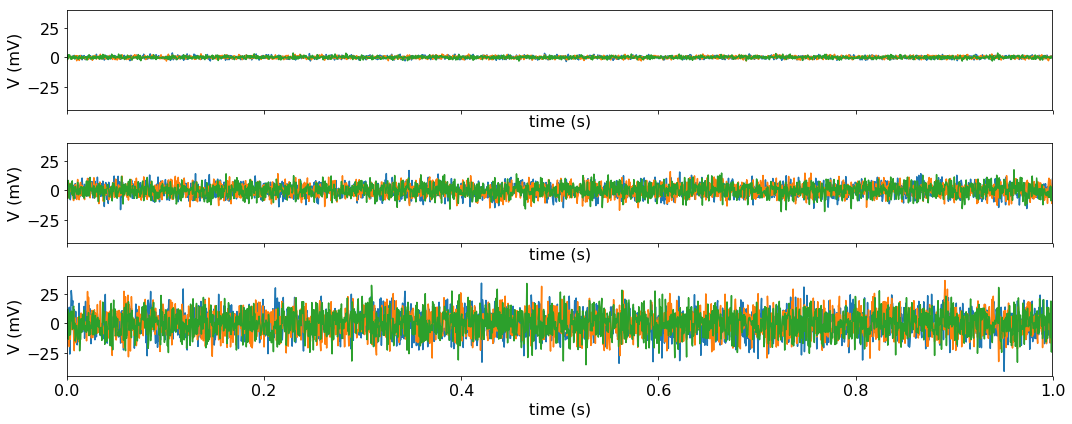

In [21]:
def test_make_noise(noise_stds, P):
    
    ntwk = Generic(n=3)
    
    n_axs = len(noise_stds)
    fig_size = (15, n_axs*2)
    
    fig, axs = plt.subplots(n_axs, 1, figsize=fig_size, sharex=True, sharey=True, squeeze=False, tight_layout=True)
    
    for noise_std, ax in zip(noise_stds, axs[:, 0]):
        
        p = Generic(
            DT=P.DT,
            T_END=1,
            NOISE_STD=noise_std
        )
        
        t, noise = make_noise(ntwk, p)
        
        ax.plot(t, 1000 * noise)
        
        ax.set_xlim(0, t[-1])
        
        
    for ax in axs[:, 0]:
        
        ax.set_xlabel('time (s)')
        ax.set_ylabel('V (mV)')
        set_font_size(ax, 16)
        
test_make_noise([0.001, 0.005, 0.01], P)

## Recall precision

In [22]:
def calc_pcsn(rsp, items, P):
    # mask OUT nrns belonging to correct items
    mask_correct_out = np.zeros(P.N_OUT, bool)
    
    for item in items:
        mask_correct_out[rsp.ntwk.labels_out[:, item]] = True
    
    # mask OUT nrns belonging to incorrect items or no items
    mask_incorrect_out = np.zeros(P.N_OUT, bool)
    
    for item in range(4):
        if item not in items:
            mask_incorrect_out[rsp.ntwk.labels_out[:, item]] = True
            
    no_item_mask = rsp.ntwk.labels_out.sum(1)
    mask_incorrect_out[no_item_mask] = True
    
    # convert OUT masks to full masks over OUT + INH nrns
    mask_correct = np.zeros(rsp.ntwk.n, bool)
    mask_correct[rsp.ntwk.masks_rcr['OUT']] = mask_correct_out
    
    mask_incorrect = np.zeros(rsp.ntwk.n, bool)
    mask_incorrect[rsp.ntwk.masks_rcr['OUT']] = mask_incorrect_out
    
    # get recall period time mask
    t_mask_recall = (P.T_RECALL_0 <= rsp.ts) & (rsp.ts < P.T_RECALL_1)
    spks_recall = rsp.spks[t_mask_recall, :]
    dur_recall = P.T_RECALL_1 - P.T_RECALL_0
    
    # measure average firing rate fr_correct over correct item neurons
    fr_correct = np.mean(spks_recall[:, mask_correct].sum(0) / dur_recall)
    
    # measure average firing rate fr_incorrect over incorrect item neurons
    fr_incorrect = np.mean(spks_recall[:, mask_incorrect].sum(0) / dur_recall)
    
    return 1 - (fr_incorrect / fr_correct)

#### Test

In [23]:
def test_calc_pcsn():
    
    ts = np.arange(0, 2, 0.0005)
    
    n_out = 500
    n_inh = 100
    
    q = 0.2
    q_star = 0
    
    items = [1]
    
    labels_out = sort_item_labels(assign_items(n=n_out, q=q, q_star=q_star))
    
    labels_out_ext = np.concatenate([labels_out, np.zeros((n_inh, 4), bool)])
    
    masks_rcr = {'OUT': np.zeros(600, bool), 'INH': np.zeros(600, bool)}
    masks_rcr['OUT'][:500] = True
    masks_rcr['INH'][500:] = True
    
    spks_template = np.zeros((len(ts), 600), bool)
    
    P = Generic(T_RECALL_0=0.5, T_RECALL_1=1.5, N_OUT=n_out)
    
    # high precision
    spks_high = spks_template.copy()
    spks_high[:, labels_out_ext[:, 1]] = True
    
    rsp_high = Generic(
        ts=ts,
        spks=spks_high,
        ntwk=Generic(labels_out=labels_out, masks_rcr=masks_rcr, n=(n_out+n_inh))
    )
    
    print_red('High precision: {}'.format(calc_pcsn(rsp_high, items, P)))
    
    # low precision
    spks_low = spks_template.copy()
    spks_low[:, labels_out_ext[:, 1]] = True
    
    spks_low[:, labels_out_ext[:, 0]] = True
    spks_low[:, labels_out_ext[:, 2]] = True
    spks_low[:, labels_out_ext[:, 3]] = True
    
    rsp_low = Generic(
        ts=ts,
        spks=spks_low,
        ntwk=Generic(labels_out=labels_out, masks_rcr=masks_rcr, n=(n_out+n_inh))
    )
    
    print_red('Low precision: {}'.format(calc_pcsn(rsp_low, items, P)))
    
    # negative precision
    spks_neg = spks_template.copy()
    spks_neg[:, labels_out_ext[:, 1].nonzero()[0][:10]] = True
    
    spks_neg[:, labels_out_ext[:, 0]] = True
    spks_neg[:, labels_out_ext[:, 2]] = True
    spks_neg[:, labels_out_ext[:, 3]] = True
    
    rsp_neg = Generic(
        ts=ts,
        spks=spks_neg,
        ntwk=Generic(labels_out=labels_out, masks_rcr=masks_rcr, n=(n_out+n_inh))
    )
    
    print_red('Neg precision: {}'.format(calc_pcsn(rsp_neg, items, P)))
    
test_calc_pcsn()

High precision: 1.0
Low precision: 0.006644518272425182
Neg precision: -8.337541528239203


Tests passed if high precision is 1, low precision is close to zero, and neg precision is very negative (more negative than -1).

# SIMULATIONS

## Examples

### Simulation code

In [24]:
def xmpl(q_star, p_0, p_1, p_g_out_inh, items, P, plot=False):
    """
    Run example simulation and output a raster plot,
    population firing rate plot, and plot of synaptic weight
    changes over time."""

    # build ntwk and run smln
    ntwk = make_ntwk(q_star=q_star, p_0=p_0, p_1=p_1, p_g_out_inh=p_g_out_inh, P=P)
    spks_up = make_spks_up(ntwk, items, P)
    noise = make_noise(ntwk, P)[1]
    
    rsp = ntwk.run(spks_up=spks_up, dt=P.DT, i_ext=noise)
    rsp.ntwk = ntwk
    pcsn = calc_pcsn(rsp, items, P)
    
    # population firing rates
    ## take moving average
    
    n_t_ma = int(P.T_FR_MA / P.DT)
    
    ### indiv items
    frs_ma = []
    
    for i in range(4):
        
        mask_i = np.zeros(ntwk.n, bool)
        mask_i[:ntwk.n][ntwk.labels_out[:, i]] = True
        
        spk_ct_i = rsp.spks[:, mask_i].mean(1)
        spk_ct_i_ma = np.convolve(spk_ct_i, np.ones(n_t_ma), mode='same')
        fr_ma = spk_ct_i_ma / P.T_FR_MA
        
        frs_ma.append(fr_ma)
    
    ### whole OUT pop
    
    spk_ct_out = rsp.spks[:, ntwk.masks_rcr['OUT']].mean(1)
    spk_ct_out_ma = np.convolve(spk_ct_out, np.ones(n_t_ma), mode='same')
    fr_out_ma = spk_ct_out_ma / P.T_FR_MA
    
    ### INH pop
    spk_ct_inh = rsp.spks[:, ntwk.masks_rcr['INH']].mean(1)
    spk_ct_inh_ma = np.convolve(spk_ct_inh, np.ones(n_t_ma), mode='same')
    fr_inh_ma = spk_ct_inh_ma / P.T_FR_MA
    
    if plot:
        # show raster and CTL->OUT weights
        fig, axs = plt.subplots(3, 1, figsize=(15, 12), tight_layout=True)

        ## raster
        raster(axs[0], rsp.ts, rsp.spks, lw=1, s=5)

        axs[0].set_ylim(0, ntwk.n)

        # plot moving averages
        colors_item = ['k', 'b', 'g', 'c']
        color_out = 'gray'
        color_inh = 'r'

        # item-specific
        for fr_ma, color in zip(frs_ma, colors_item):
            axs[1].plot(rsp.ts, fr_ma, lw=2, color=color)

        # entire OUT
        axs[1].plot(rsp.ts, fr_out_ma, lw=2, color=color_out)

        # entire INH
        axs[1].plot(rsp.ts, fr_inh_ma, lw=2, color=color_inh, ls='--')

        axs[1].set_xlabel('time (s)')
        axs[1].set_ylabel('firing rate (Hz)')

        axs[1].legend(['Item 1', 'Item 2', 'Item 3', 'Item 4', 'OUT', 'INH'])

        axs[0].set_title('PRECISION = {0:.4f}'.format(pcsn))

        for ax in axs:
            set_font_size(ax, 16)
        
    return Generic(
        ntwk=ntwk,
        items=items,
        spks_up=spks_up,
        rsp=rsp,
        frs_ma=frs_ma,
        fr_out_ma=fr_out_ma,
        fr_inh_ma=fr_inh_ma,
        pcsn=pcsn)

<a id="simulations"></a>
[Jump to fixed parameters](#params)

## Parameter sweep

### Function definition

In [25]:
def vary_params(q_stars, p_1s, p_g_out_inhs, n_trials, save_file, print_every=20):
    
    df = pd.DataFrame(columns=['q_star', 'p_1', 'p_g_out_inh', 'trial', 'pcsn'])
    
    total_trials = len(q_stars) * len(p_1s) * len(p_g_out_inhs) * n_trials
    
    ctr = 0
    
    for q_star, p_1, p_g_out_inh in c_product(q_stars, p_1s, p_g_out_inhs):
        
        for trial in range(n_trials):
            
            if ctr == 0 or ((ctr+1) % print_every == 0):
                print('Running trial {}/{}...'.format(ctr+1, total_trials))
                
            rslt = xmpl(q_star=q_star, p_0=P.P_A_OUT_OUT, p_1=p_1, p_g_out_inh=p_g_out_inh, items=[0], P=P)

            df.loc[ctr] = {
                'q_star': q_star,
                'p_1': p_1,
                'p_g_out_inh': p_g_out_inh,
                'trial': int(trial+1),
                'pcsn': copy(rslt.pcsn),
            }
            
            df.to_csv(save_file)
            
            rslt = None
            
            ctr += 1

    return df

### Analysis

In [26]:
np.random.seed(0)

q_stars = [0., 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
p_1s = [0.05, 0.1, 0.2]
p_g_out_inhs=[0.0, 0.1, 0.2, 0.35, 0.5]
n_trials = 30

save_file = '2_item_recall_params_sweep.csv'

In [ ]:
#df = vary_params(
    q_stars=q_stars,
    p_1s=p_1s,
    p_g_out_inhs=p_g_out_inhs,
    n_trials=n_trials,
    save_file=save_file,
    print_every=10)

### Results

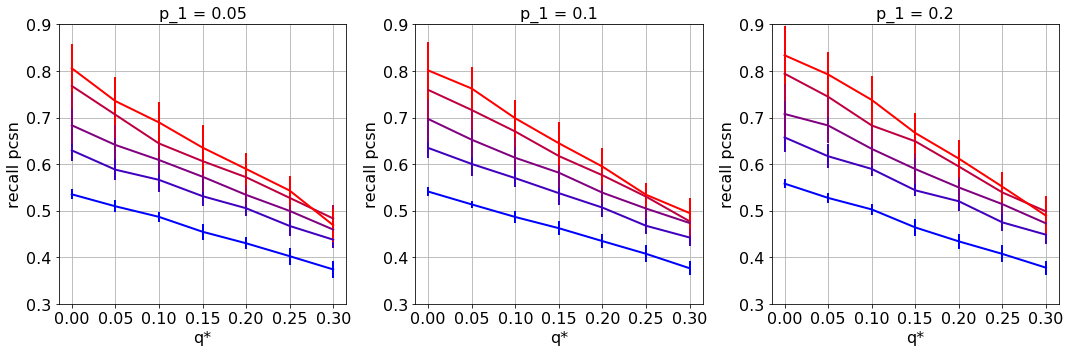

In [38]:
colors = spaced_colors((0, 0, 1), (1, 0, 0), 5)

# load datafile
df = pd.read_csv(save_file, index_col=0)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)

for p_1, ax in zip(p_1s, axs):
    
    mask_p_1 = ((0.99 * p_1) <= df['p_1']) & (df['p_1'] < (1.01 * p_1))
    
    for p_g_out_inh, color in zip(p_g_out_inhs, colors):
        
        mask_p_g_out_inh = ((p_g_out_inh - .0001) <= df['p_g_out_inh']) \
            & (df['p_g_out_inh'] < (p_g_out_inh + .0001))
        
        df_sub = df[mask_p_1 & mask_p_g_out_inh].sort_values(['q_star', 'trial'])
        
        grouped = df_sub.groupby(['q_star']).agg([np.mean, np.std])['pcsn']
        
        ax.errorbar(grouped.index.values, grouped['mean'], yerr=grouped['std'], color=color, lw=2)
    
    ax.set_ylim(0.3, 0.9)
    
    ax.grid()
    
    ax.set_xlabel('q*')
    ax.set_ylabel('recall precision')
    ax.set_title('p_1 = {}'.format(p_1))
    
    set_font_size(ax, 16)

### Single-item, overlap, equal inter/intra recurrence

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 600 but corresponding boolean dimension is 500


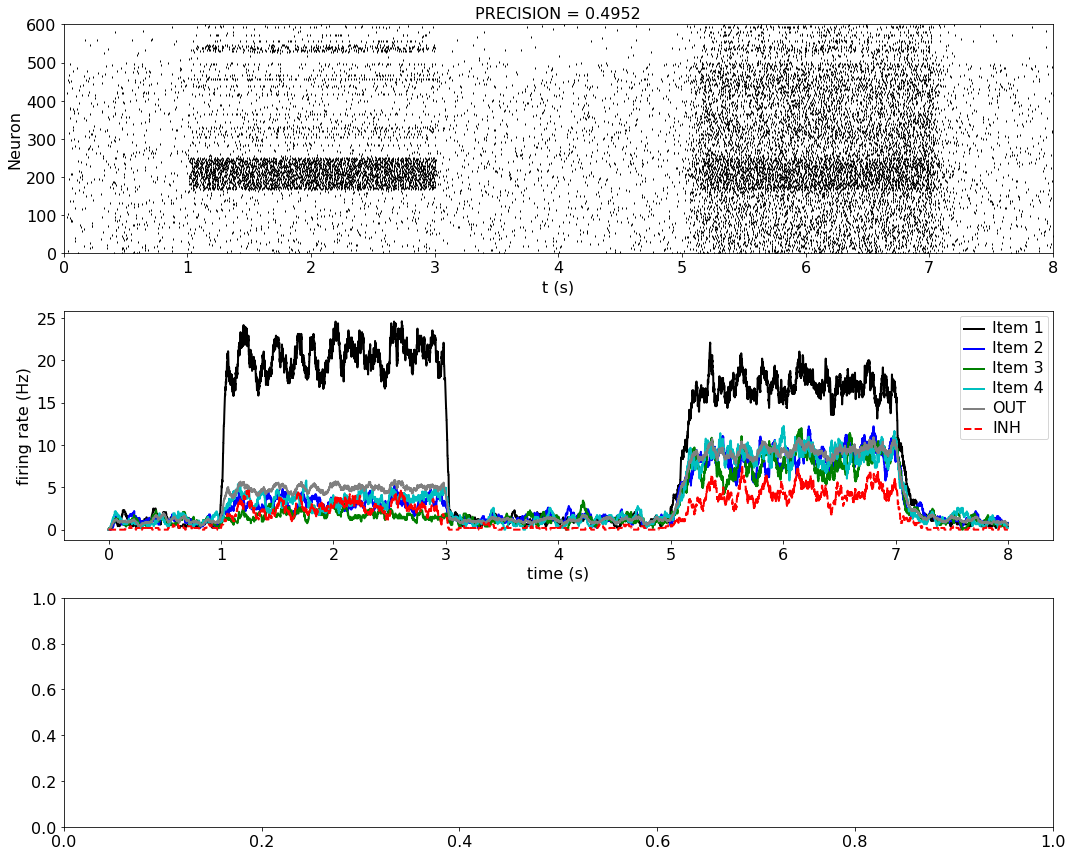

In [41]:
np.random.seed(0)
rslt = xmpl(q_star=0.1, p_0=P.P_A_OUT_OUT, p_1=0.2, p_g_out_inh=0.0, items=[0], P=P, plot=True)

/Users/rkp/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:27: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 600 but corresponding boolean dimension is 500


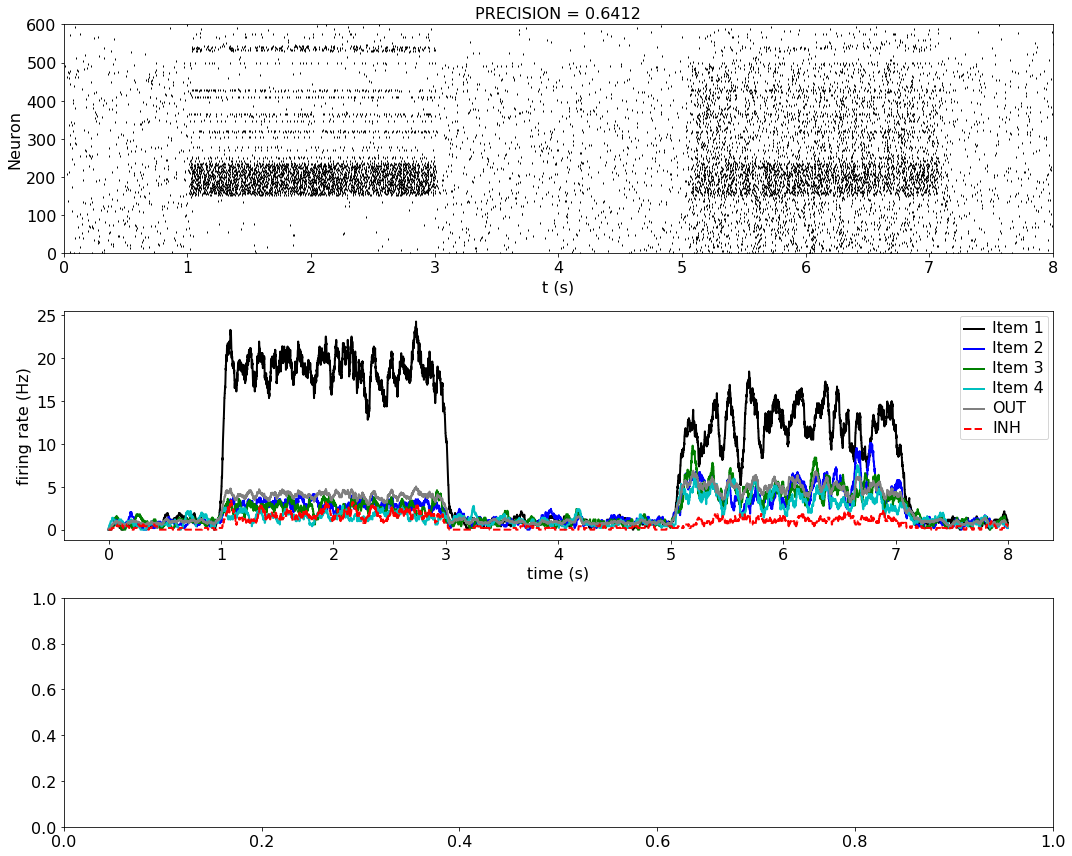

In [42]:
np.random.seed(1)
rslt = xmpl(q_star=0.1, p_0=P.P_A_OUT_OUT, p_1=0.2, p_g_out_inh=0.5, items=[0], P=P, plot=True)